## Import

In [1]:
import pandas as pd
import os
import os.path as osp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
data_dir = '../dataset/housing'

train = pd.read_csv(osp.join(data_dir, 'train.csv'))
test = pd.read_csv(osp.join(data_dir, 'test.csv'))

train.drop('id', axis = 1, inplace = True) # id 제거
test.drop('id', axis = 1, inplace = True)
print(train.shape, test.shape)

train.head()

(1350, 14) (1350, 13)


,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


## EDA

import pandas_profiling
profile = train.profile_report()
profile

## Preprocessing

### 1. 중복값 제거

In [3]:
print('제거 전: ', train.shape)
train = train.drop_duplicates()
print('제거 후: ', train.shape)

제거 전:  (1350, 14)
제거 후:  (1349, 14)


In [4]:
# train[train['Garage Yr Blt']> 2050] # 254
train.loc[254, 'Garage Yr Blt'] = 2007

- Poor(po) -> Fa(Fair) -> Typical/Average(TA) -> Good(Gd) -> Excellent(Ex)
    - 각 1 ~ 5로 매핑.
    
- sklearn.preprocessing.LabelEncoder를 사용할 수도 있지만, 품질이 좋을수록 더 높은 값으로 지정해주기 위해 직접 매핑 수행.

In [5]:
# 품질 관련 변수 -> 숫자로 매핑
# train.dtypes == np.object: 숫자 관련 변수면 False, 범주형 변수면 True.
# train.dtypes[train.dtypes == np.object]: True인 변수의 dtype을 출력.
# train.dtypes[train.dtypes == np.object].index: 해당 변수의 이름을 출력.
qual_cols = train.dtypes[train.dtypes == np.object].index

def label_encoder(df_, qual_cols):
    df = df_.copy()
    mapping={
        'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1
    }
    
    for col in qual_cols:
        df[col] = df[col].map(mapping)
        
    return df

train = label_encoder(train, qual_cols)
test = label_encoder(test, qual_cols)
train.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,10,2392,5,3,968,5,2392,2392,5,2,2003,2003,2003,386250
1,7,1352,4,2,466,4,1352,1352,5,2,2006,2007,2006,194000
2,5,900,3,1,288,3,864,900,3,1,1967,1967,1967,123000
3,5,1174,3,2,576,4,680,680,3,1,1900,2006,2000,135000
4,7,1958,4,3,936,4,1026,1026,4,2,2005,2005,2005,250000


In [6]:
test.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt
0,9,1800,4,2,702,5,1800,1800,5,2,2007,2007,2007
1,6,1082,3,1,240,3,1082,1082,3,1,1948,1950,1948
2,6,1573,4,2,440,4,756,769,4,2,2000,2000,2000
3,6,2443,4,3,744,4,1158,1158,4,2,2004,2004,2004
4,5,1040,3,2,686,3,1040,1040,3,1,1968,1968,1991


### Overall Qual

In [19]:
train['Overall Qual'].value_counts()

5     379
6     351
7     306
8     156
4      75
9      56
10     15
3       8
2       3
Name: Overall Qual, dtype: int64

In [24]:
test['Overall Qual'].value_counts()

6     356
5     349
7     287
8     191
4     100
9      51
10     16
Name: Overall Qual, dtype: int64

In [20]:
train['Overall Qual'][train['Overall Qual'] < 4] = 4
test['Overall Qual'][test['Overall Qual'] < 4] = 4

### Exter Qual

In [7]:
# Exter Qual 분포
train['Exter Qual'].value_counts()

3    807
4    485
5     49
2      8
Name: Exter Qual, dtype: int64

In [8]:
test['Exter Qual'].value_counts()

3    794
4    489
5     58
2      9
Name: Exter Qual, dtype: int64

In [22]:
train['Exter Qual'][train['Exter Qual'] == 2] = 3
test['Exter Qual'][test['Exter Qual'] == 2] = 3

In [23]:
train['Exter Qual'].value_counts()

3    815
4    485
5     49
Name: Exter Qual, dtype: int64

### Garage Cars

In [25]:
train['Garage Cars'].value_counts()

2    794
1    372
3    172
4     10
5      1
Name: Garage Cars, dtype: int64

In [26]:
test['Garage Cars'].value_counts()

2    767
1    380
3    199
4      4
Name: Garage Cars, dtype: int64

In [27]:
train['Garage Cars'][train['Garage Cars'] == 5] = 4
test['Garage Cars'][test['Garage Cars'] == 5] = 4

In [28]:
train['Garage Cars'].value_counts()

2    794
1    372
3    172
4     11
Name: Garage Cars, dtype: int64

### Kitchen Qual

In [29]:
train['Kitchen Qual'].value_counts()

3    659
4    560
5    107
2     23
Name: Kitchen Qual, dtype: int64

In [30]:
test['Kitchen Qual'].value_counts()

3    666
4    566
5     94
2     23
1      1
Name: Kitchen Qual, dtype: int64

In [31]:
train['Kitchen Qual'][train['Kitchen Qual'] == 1] = 2
train['Kitchen Qual'][train['Kitchen Qual'] == 2] = 3

test['Kitchen Qual'][test['Kitchen Qual'] == 1] = 2
test['Kitchen Qual'][test['Kitchen Qual'] == 2] = 3

In [32]:
train['Kitchen Qual'].value_counts()

3    682
4    560
5    107
Name: Kitchen Qual, dtype: int64

In [33]:
test['Kitchen Qual'].value_counts()

3    690
4    566
5     94
Name: Kitchen Qual, dtype: int64

### Bsmt Qual

In [34]:
train['Bsmt Qual'].value_counts()

3    605
4    582
5    133
2     28
1      1
Name: Bsmt Qual, dtype: int64

In [35]:
test['Bsmt Qual'].value_counts()

4    597
3    582
5    124
2     46
1      1
Name: Bsmt Qual, dtype: int64

In [36]:
train['Bsmt Qual'][train['Bsmt Qual'] == 1] = 2
train['Bsmt Qual'][train['Bsmt Qual'] == 2] = 3

test['Bsmt Qual'][test['Bsmt Qual'] == 1] = 2
test['Bsmt Qual'][test['Bsmt Qual'] == 2] = 3

In [37]:
train['Bsmt Qual'].value_counts()

3    634
4    582
5    133
Name: Bsmt Qual, dtype: int64

In [38]:
test['Bsmt Qual'].value_counts()

3    629
4    597
5    124
Name: Bsmt Qual, dtype: int64

### Full Bath

In [39]:
train['Full Bath'].value_counts()

2    703
1    612
3     27
0      6
4      1
Name: Full Bath, dtype: int64

In [40]:
test['Full Bath'].value_counts()

2    746
1    567
3     30
0      5
4      2
Name: Full Bath, dtype: int64

In [43]:
train['Full Bath'][train['Full Bath'] == 0] = 1
train['Full Bath'][train['Full Bath'] == 4] = 3

test['Full Bath'][test['Full Bath'] == 0] = 1
test['Full Bath'][test['Full Bath'] == 4] = 3

In [44]:
train['Full Bath'].value_counts()

2    703
1    618
3     28
Name: Full Bath, dtype: int64

In [45]:
test['Full Bath'].value_counts()

2    746
1    572
3     32
Name: Full Bath, dtype: int64

### 1.2 파생변수

In [46]:
def feature_eng(data_):
    data = data_.copy()
    data['Year Gap Remod'] = data['Year Remod/Add'] - data['Year Built']
    data['Car Area'] = data['Garage Area']/data['Garage Cars']
    data['2nd flr SF'] = data['Gr Liv Area'] - data['1st Flr SF']
    data['2nd flr'] = data['2nd flr SF'].apply(lambda x : 1 if x > 0 else 0)
    data['Total SF'] = data[['Gr Liv Area',"Garage Area", "Total Bsmt SF"]].sum(axis=1)
    data['Sum Qual'] = data[["Exter Qual", "Kitchen Qual", "Overall Qual"]].sum(axis=1)
    data['Garage InOut'] = data.apply(lambda x : 1 if x['Gr Liv Area'] != x['1st Flr SF'] else 0, axis=1)
    return data

train = feature_eng(train)
test = feature_eng(test)

In [47]:
train.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,...,Year Remod/Add,Garage Yr Blt,target,Year Gap Remod,Car Area,2nd flr SF,2nd flr,Total SF,Sum Qual,Garage InOut
0,10,2392,5,3,968,5,2392,2392,5,2,...,2003,2003,386250,0,322.666667,0,0,5752,20,0
1,7,1352,4,2,466,4,1352,1352,5,2,...,2007,2006,194000,1,233.000000,0,0,3170,15,0
2,5,900,3,1,288,3,864,900,3,1,...,1967,1967,123000,0,288.000000,0,0,2052,11,0
3,5,1174,3,2,576,4,680,680,3,1,...,2006,2000,135000,106,288.000000,494,1,2430,12,1
4,7,1958,4,3,936,4,1026,1026,4,2,...,2005,2005,250000,0,312.000000,932,1,3920,15,1


In [48]:
test.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,Year Gap Remod,Car Area,2nd flr SF,2nd flr,Total SF,Sum Qual,Garage InOut
0,9,1800,4,2,702,5,1800,1800,5,2,2007,2007,2007,0,351.0,0,0,4302,18,0
1,6,1082,3,1,240,3,1082,1082,3,1,1948,1950,1948,2,240.0,0,0,2404,12,0
2,6,1573,4,2,440,4,756,769,4,2,2000,2000,2000,0,220.0,804,1,2769,14,1
3,6,2443,4,3,744,4,1158,1158,4,2,2004,2004,2004,0,248.0,1285,1,4345,14,1
4,5,1040,3,2,686,3,1040,1040,3,1,1968,1968,1991,0,343.0,0,0,2766,11,0


### 1.5 정규화

In [49]:
from sklearn.preprocessing import MinMaxScaler

num_features = ['Overall Qual', 'Gr Liv Area', 'Garage Cars',
       'Garage Area', 'Total Bsmt SF', '1st Flr SF',
       'Full Bath', 'Year Built', 'Year Remod/Add',
       'Garage Yr Blt','Year Gap Remod','Car Area',
                '2nd flr SF', 'Total SF','Sum Qual']

cat_features = ["Exter Qual", "Kitchen Qual","Bsmt Qual",
                "2nd flr", "Garage InOut"]

#### train 데이터 정규화

In [50]:
scaler = MinMaxScaler()

In [51]:
train[num_features] = scaler.fit_transform(train[num_features])

In [52]:
train.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,...,Year Remod/Add,Garage Yr Blt,target,Year Gap Remod,Car Area,2nd flr SF,2nd flr,Total SF,Sum Qual,Garage InOut
0,1.000000,0.478478,5,0.666667,0.625360,5,0.895108,0.790736,5,0.5,...,0.883333,0.936364,386250,0.000000,0.270227,0.000000,0,0.701005,1.0,0
1,0.500000,0.218218,4,0.333333,0.263689,4,0.488063,0.360629,5,0.5,...,0.950000,0.963636,194000,0.008130,0.161408,0.000000,0,0.301624,0.5,0
2,0.166667,0.105105,3,0.000000,0.135447,3,0.297065,0.173697,3,0.0,...,0.283333,0.609091,123000,0.000000,0.228155,0.000000,0,0.128693,0.1,0
3,0.166667,0.173674,3,0.333333,0.342939,4,0.225049,0.082713,3,0.0,...,0.933333,0.909091,135000,0.861789,0.228155,0.236364,1,0.187162,0.2,1
4,0.500000,0.369870,4,0.666667,0.602305,4,0.360470,0.225806,4,0.5,...,0.916667,0.954545,250000,0.000000,0.257282,0.445933,1,0.417633,0.5,1


#### test 데이터 정규화

In [53]:
test[num_features] = scaler.transform(test[num_features])

In [54]:
test.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,Year Gap Remod,Car Area,2nd flr SF,2nd flr,Total SF,Sum Qual,Garage InOut
0,0.833333,0.330330,4,0.333333,0.433718,5,0.663405,0.545906,5,0.5,0.976923,0.950000,0.972727,0.00000,0.304612,0.000000,0,0.476721,0.8,0
1,0.333333,0.150651,3,0.000000,0.100865,3,0.382387,0.248966,3,0.0,0.523077,0.000000,0.436364,0.01626,0.169903,0.000000,0,0.183140,0.2,0
2,0.333333,0.273524,4,0.333333,0.244957,4,0.254795,0.119520,4,0.5,0.923077,0.833333,0.909091,0.00000,0.145631,0.384689,1,0.239598,0.4,1
3,0.333333,0.491241,4,0.666667,0.463977,4,0.412133,0.280397,4,0.5,0.953846,0.900000,0.945455,0.00000,0.179612,0.614833,1,0.483372,0.4,1
4,0.166667,0.140140,3,0.333333,0.422190,3,0.365949,0.231596,3,0.0,0.676923,0.300000,0.827273,0.00000,0.294903,0.000000,0,0.239134,0.1,0


### 타겟 로그 변환

In [55]:
# 로그 변환 전, 후 비교
print(f'로그 변환 전 타겟 왜도 = {train.target.skew()} / 로그 변환 후 타겟 왜도 = {np.log1p(train.target).skew()}')

로그 변환 전 타겟 왜도 = 1.7205733874129123 / 로그 변환 후 타겟 왜도 = 0.08224141935772546


In [56]:
from scipy.stats import norm, skew

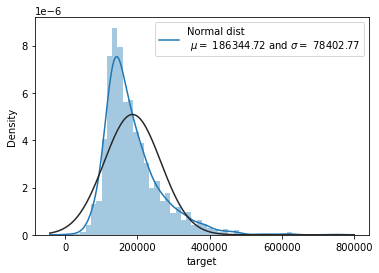

In [57]:
# 그래프로 확인
sns.distplot(train.target, fit = norm)
(mu, sigma) = norm.fit(train['target'])
plt.legend(['Normal dist\n $\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

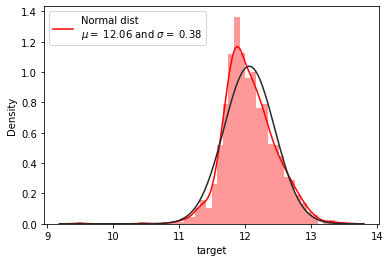

In [58]:
# 타겟 값 로그 변환
sns.distplot(np.log1p(train.target), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(train['target']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

#### train, target 분리

In [59]:
train_x = train.drop('target', axis = 1)
train_y = np.log1p(train.target)

target = test[train_x.columns]

In [60]:
target.fillna(target.mean(), inplace = True)

In [61]:
train_x.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,Year Gap Remod,Car Area,2nd flr SF,2nd flr,Total SF,Sum Qual,Garage InOut
0,1.000000,0.478478,5,0.666667,0.625360,5,0.895108,0.790736,5,0.5,0.946154,0.883333,0.936364,0.000000,0.270227,0.000000,0,0.701005,1.0,0
1,0.500000,0.218218,4,0.333333,0.263689,4,0.488063,0.360629,5,0.5,0.969231,0.950000,0.963636,0.008130,0.161408,0.000000,0,0.301624,0.5,0
2,0.166667,0.105105,3,0.000000,0.135447,3,0.297065,0.173697,3,0.0,0.669231,0.283333,0.609091,0.000000,0.228155,0.000000,0,0.128693,0.1,0
3,0.166667,0.173674,3,0.333333,0.342939,4,0.225049,0.082713,3,0.0,0.153846,0.933333,0.909091,0.861789,0.228155,0.236364,1,0.187162,0.2,1
4,0.500000,0.369870,4,0.666667,0.602305,4,0.360470,0.225806,4,0.5,0.961538,0.916667,0.954545,0.000000,0.257282,0.445933,1,0.417633,0.5,1


In [62]:
train_y.head() # 로그변환을 진행한 train_y (target)

0    12.864243
1    12.175619
2    11.719948
3    11.813037
4    12.429220
Name: target, dtype: float64

In [63]:
target.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,Year Gap Remod,Car Area,2nd flr SF,2nd flr,Total SF,Sum Qual,Garage InOut
0,0.833333,0.330330,4,0.333333,0.433718,5,0.663405,0.545906,5,0.5,0.976923,0.950000,0.972727,0.00000,0.304612,0.000000,0,0.476721,0.8,0
1,0.333333,0.150651,3,0.000000,0.100865,3,0.382387,0.248966,3,0.0,0.523077,0.000000,0.436364,0.01626,0.169903,0.000000,0,0.183140,0.2,0
2,0.333333,0.273524,4,0.333333,0.244957,4,0.254795,0.119520,4,0.5,0.923077,0.833333,0.909091,0.00000,0.145631,0.384689,1,0.239598,0.4,1
3,0.333333,0.491241,4,0.666667,0.463977,4,0.412133,0.280397,4,0.5,0.953846,0.900000,0.945455,0.00000,0.179612,0.614833,1,0.483372,0.4,1
4,0.166667,0.140140,3,0.333333,0.422190,3,0.365949,0.231596,3,0.0,0.676923,0.300000,0.827273,0.00000,0.294903,0.000000,0,0.239134,0.1,0


## Modeling

In [64]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from catboost import CatBoostRegressor, Pool
from ngboost import NGBRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

In [65]:
# 평가 기준 정의
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [66]:
nmae_score = make_scorer(NMAE, greater_is_better = False)

# 10 FOLD로 앙상블.
# 모델별로 10fold의 target 예측값을 만들어 평균 값을 취해줌.
kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

In [67]:
# 1.LinearRegression
lr_pred = np.zeros(target.shape[0])
lr_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    lr = LinearRegression(normalize=True)
    lr.fit(tr_x, tr_y)
    
    val_pred = np.expm1(lr.predict(val_x))
    val_nmae = NMAE(val_y, val_pred)
    lr_val.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    target_data = Pool(data = target, label = None)
    fold_pred = lr.predict(target)/10
    lr_pred += fold_pred
    
print(f'10FOLD Mean of NMAE = {np.mean(lr_val)} & std = {np.std(lr_val)}')

1 FOLD Training.....
1 FOLD NMAE = 0.08790570049566104

2 FOLD Training.....
2 FOLD NMAE = 0.10413534340456457

3 FOLD Training.....
3 FOLD NMAE = 0.09512628198353293

4 FOLD Training.....
4 FOLD NMAE = 0.11920709954209958

5 FOLD Training.....
5 FOLD NMAE = 0.08432437458243754

6 FOLD Training.....
6 FOLD NMAE = 0.10783064573463741

7 FOLD Training.....
7 FOLD NMAE = 0.09947914625358045

8 FOLD Training.....
8 FOLD NMAE = 0.09293910334068238

9 FOLD Training.....
9 FOLD NMAE = 0.10072712134360289

10 FOLD Training.....
10 FOLD NMAE = 0.10014932387622981

10FOLD Mean of NMAE = 0.09918241405570286 & std = 0.009524060458205561


In [68]:
# 2.Ridge
rg_pred = np.zeros(target.shape[0])
rg_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    rg = Ridge()
    rg.fit(tr_x, tr_y)
    
    val_pred = np.expm1(rg.predict(val_x))
    val_nmae = NMAE(val_y, val_pred)
    rg_val.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    target_data = Pool(data = target, label = None)
    fold_pred = rg.predict(target) / 10
    rg_pred += fold_pred
    
print(f'10FOLD Mean of NMAE = {np.mean(rg_val)} & std = {np.std(rg_val)}')

1 FOLD Training.....
1 FOLD NMAE = 0.08548352773469522

2 FOLD Training.....
2 FOLD NMAE = 0.10521173163851258

3 FOLD Training.....
3 FOLD NMAE = 0.09396066568169845

4 FOLD Training.....
4 FOLD NMAE = 0.11927994343888747

5 FOLD Training.....
5 FOLD NMAE = 0.08208816800745487

6 FOLD Training.....
6 FOLD NMAE = 0.1065511589493152

7 FOLD Training.....
7 FOLD NMAE = 0.09702403720241218

8 FOLD Training.....
8 FOLD NMAE = 0.08888738832534597

9 FOLD Training.....
9 FOLD NMAE = 0.09939149729873223

10 FOLD Training.....
10 FOLD NMAE = 0.0990693572622095

10FOLD Mean of NMAE = 0.09769474755392635 & std = 0.010441610395290363


In [69]:
# 3.Lasso
ls_pred = np.zeros(target.shape[0])
ls_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    ls = Lasso()
    ls.fit(tr_x, tr_y)
    
    val_pred = np.expm1(ls.predict(val_x))
    val_nmae = NMAE(val_y, val_pred)
    ls_val.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    target_data = Pool(data = target, label = None)
    fold_pred = ls.predict(target)/10
    ls_pred += fold_pred
    
print(f'10FOLD Mean of NMAE = {np.mean(ls_val)} & std = {np.std(ls_val)}')

1 FOLD Training.....
1 FOLD NMAE = 0.29182411589738233

2 FOLD Training.....
2 FOLD NMAE = 0.28703089668815873

3 FOLD Training.....
3 FOLD NMAE = 0.31634967223712895

4 FOLD Training.....
4 FOLD NMAE = 0.3006171491482618

5 FOLD Training.....
5 FOLD NMAE = 0.3123287999543719

6 FOLD Training.....
6 FOLD NMAE = 0.3197531329297223

7 FOLD Training.....
7 FOLD NMAE = 0.26921672140423736

8 FOLD Training.....
8 FOLD NMAE = 0.25317220335529567

9 FOLD Training.....
9 FOLD NMAE = 0.2961017042752361

10 FOLD Training.....
10 FOLD NMAE = 0.34407588581481974

10FOLD Mean of NMAE = 0.29904702817046147 & std = 0.024767261843614274


In [70]:
# 4.ElasticNet
el_pred = np.zeros(target.shape[0])
el_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    el = ElasticNet()
    el.fit(tr_x, tr_y)
    
    val_pred = np.expm1(el.predict(val_x))
    val_nmae = NMAE(val_y, val_pred)
    el_val.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    target_data = Pool(data = target, label = None)
    fold_pred = el.predict(target) / 10
    el_pred += fold_pred
    
print(f'10FOLD Mean of NMAE = {np.mean(el_val)} & std = {np.std(el_val)}')

1 FOLD Training.....
1 FOLD NMAE = 0.29182411589738233

2 FOLD Training.....
2 FOLD NMAE = 0.28703089668815873

3 FOLD Training.....
3 FOLD NMAE = 0.31634967223712895

4 FOLD Training.....
4 FOLD NMAE = 0.3006171491482618

5 FOLD Training.....
5 FOLD NMAE = 0.3123287999543719

6 FOLD Training.....
6 FOLD NMAE = 0.3197531329297223

7 FOLD Training.....
7 FOLD NMAE = 0.26921672140423736

8 FOLD Training.....
8 FOLD NMAE = 0.25317220335529567

9 FOLD Training.....
9 FOLD NMAE = 0.2961017042752361

10 FOLD Training.....
10 FOLD NMAE = 0.34407588581481974

10FOLD Mean of NMAE = 0.29904702817046147 & std = 0.024767261843614274


In [71]:
# 5.RandomForest
rf_pred = np.zeros(target.shape[0])
rf_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    rf = RandomForestRegressor(random_state = 42, criterion = 'mae')
    rf.fit(tr_x, tr_y)
    
    val_pred = np.expm1(rf.predict(val_x))
    val_nmae = NMAE(val_y, val_pred)
    rf_val.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    fold_pred = rf.predict(target) / 10
    rf_pred += fold_pred
    
print(f'10FOLD Mean of NMAE = {np.mean(rf_val)} & std = {np.std(rf_val)}')

1 FOLD Training.....
1 FOLD NMAE = 0.08954538531805166

2 FOLD Training.....
2 FOLD NMAE = 0.09670201872826625

3 FOLD Training.....
3 FOLD NMAE = 0.09737447264397112

4 FOLD Training.....
4 FOLD NMAE = 0.12074778400757272

5 FOLD Training.....
5 FOLD NMAE = 0.09020722976241219

6 FOLD Training.....
6 FOLD NMAE = 0.10195605852556562

7 FOLD Training.....
7 FOLD NMAE = 0.08894646455899395

8 FOLD Training.....
8 FOLD NMAE = 0.08540230707515879

9 FOLD Training.....
9 FOLD NMAE = 0.09667178177467178

10 FOLD Training.....
10 FOLD NMAE = 0.10868512140017933

10FOLD Mean of NMAE = 0.09762386237948435 & std = 0.010112296734515774


In [72]:
# 6.GradientBoosting
gbr_pred = np.zeros(target.shape[0])
gbr_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    gbr = GradientBoostingRegressor(random_state = 42, max_depth = 4, learning_rate = 0.05, n_estimators = 1000)
    gbr.fit(tr_x, tr_y)
    
    val_pred = np.expm1(gbr.predict(val_x))
    val_nmae = NMAE(val_y, val_pred)
    gbr_val.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    fold_pred = gbr.predict(target) / 10
    gbr_pred += fold_pred
    
print(f'10FOLD Mean of NMAE = {np.mean(gbr_val)} & std = {np.std(gbr_val)}')

1 FOLD Training.....
1 FOLD NMAE = 0.08714271724217416

2 FOLD Training.....
2 FOLD NMAE = 0.0990390155482399

3 FOLD Training.....
3 FOLD NMAE = 0.09539231526113488

4 FOLD Training.....
4 FOLD NMAE = 0.12108085739492006

5 FOLD Training.....
5 FOLD NMAE = 0.09750989076330271

6 FOLD Training.....
6 FOLD NMAE = 0.09548634228388958

7 FOLD Training.....
7 FOLD NMAE = 0.09283618803294492

8 FOLD Training.....
8 FOLD NMAE = 0.09376919380297809

9 FOLD Training.....
9 FOLD NMAE = 0.09649524996592392

10 FOLD Training.....
10 FOLD NMAE = 0.10905831724991721

10FOLD Mean of NMAE = 0.09878100875454254 & std = 0.009099782434643575


In [73]:
# 7.CatBoost
cb_pred = np.zeros(target.shape[0])
cb_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    tr_data = Pool(data = tr_x, label = tr_y)
    val_data = Pool(data = val_x, label = val_y)
    
    cb = CatBoostRegressor(depth = 4, random_state = 42, loss_function = 'MAE', n_estimators = 3000, learning_rate = 0.03, verbose = 0)
    cb.fit(tr_data, eval_set = val_data, early_stopping_rounds = 750, verbose = 1000)
    
    val_pred = np.expm1(cb.predict(val_x))
    val_nmae = NMAE(val_y, val_pred)
    cb_val.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    target_data = Pool(data = target, label = None)
    fold_pred = cb.predict(target) / 10
    cb_pred += fold_pred
    
print(f'10FOLD Mean of NMAE = {np.mean(cb_val)} & std = {np.std(cb_val)}')

1 FOLD Training.....
0:	learn: 0.2927396	test: 187886.6143315	best: 187886.6143315 (0)	total: 136ms	remaining: 6m 49s
Stopped by overfitting detector  (750 iterations wait)

bestTest = 187886.5528
bestIteration = 156

Shrink model to first 157 iterations.
1 FOLD NMAE = 0.09108706429690325

2 FOLD Training.....
0:	learn: 0.2949456	test: 183672.7370821	best: 183672.7370821 (0)	total: 1.02ms	remaining: 3.07s
Stopped by overfitting detector  (750 iterations wait)

bestTest = 183672.7233
bestIteration = 86

Shrink model to first 87 iterations.
2 FOLD NMAE = 0.114288374143449

3 FOLD Training.....
0:	learn: 0.2878097	test: 190826.8666223	best: 190826.8666223 (0)	total: 1.11ms	remaining: 3.33s
1000:	learn: 0.0669636	test: 190826.7975319	best: 190826.7973239 (923)	total: 821ms	remaining: 1.64s
Stopped by overfitting detector  (750 iterations wait)

bestTest = 190826.7972
bestIteration = 1204

Shrink model to first 1205 iterations.
3 FOLD NMAE = 0.08772660517739386

4 FOLD Training.....
0:	lear

In [74]:
# 8.NGBoost
ngb_pred = np.zeros(target.shape[0])
ngb_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    ngb = NGBRegressor(random_state = 42, n_estimators = 1000, verbose = 0, learning_rate = 0.03)
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 300)
    
    val_pred = np.expm1(ngb.predict(val_x))
    val_nmae = NMAE(val_y, val_pred)
    ngb_val.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    target_data = Pool(data = target, label = None)
    fold_pred = ngb.predict(target) / 10
    ngb_pred += fold_pred
print(f'10FOLD Mean of NMAE = {np.mean(ngb_val)} & std = {np.std(ngb_val)}')

1 FOLD Training.....
1 FOLD NMAE = 0.08034135279617617

2 FOLD Training.....
2 FOLD NMAE = 0.09780402084989054

3 FOLD Training.....
3 FOLD NMAE = 0.09241881017373914

4 FOLD Training.....
4 FOLD NMAE = 0.11709711081773591

5 FOLD Training.....
5 FOLD NMAE = 0.0926518135630681

6 FOLD Training.....
6 FOLD NMAE = 0.1015365949579448

7 FOLD Training.....
7 FOLD NMAE = 0.09448872368970493

8 FOLD Training.....
8 FOLD NMAE = 0.08560405239187552

9 FOLD Training.....
9 FOLD NMAE = 0.09278260535145591

10 FOLD Training.....
10 FOLD NMAE = 0.10491470684148357

10FOLD Mean of NMAE = 0.09596397914330745 & std = 0.009738558924105925


In [75]:
# 9.XGBoost
xgb_pred = np.zeros(target.shape[0])
xgb_val = []

for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    # xgb 학습
    xgb = XGBRegressor(random_state = 42, criterion = 'mae')
    xgb.fit(tr_x, tr_y)
    
    val_pred = np.expm1(xgb.predict(val_x))
    val_nmae = NMAE(val_y, val_pred) # NMAE
    xgb_val.append(val_nmae) # 초기화한 리스트에 NMAE를 삽입.
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    fold_pred = xgb.predict(target) / 10
    xgb_pred += fold_pred

print(f'10FOLD Mean of NMAE = {np.mean(xgb_val)} & std = {np.std(xgb_val)}')

1 FOLD Training.....
[14:23:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


1 FOLD NMAE = 0.09508982834371095

2 FOLD Training.....
[14:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


2 FOLD NMAE = 0.10841067048223482

3 FOLD Training.....
[14:23:59] WARNING: C:/Users/Ad

In [76]:
# 10.LGBM
lgbm_pred = np.zeros(target.shape[0])
lgbm_val = []

for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    # xgb 학습
    lgbm = LGBMRegressor(random_state = 42, criterion = 'mae')
    lgbm.fit(tr_x, tr_y)
    
    val_pred = np.expm1(lgbm.predict(val_x))
    val_nmae = NMAE(val_y, val_pred) # NMAE
    lgbm_val.append(val_nmae) # 초기화한 리스트에 NMAE를 삽입.
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    fold_pred = lgbm.predict(target) / 10
    lgbm_pred += fold_pred

print(f'10FOLD Mean of NMAE = {np.mean(lgbm_val)} & std = {np.std(lgbm_val)}')

1 FOLD Training.....
[LightGBM] [Warning] Unknown parameter: criterion
1 FOLD NMAE = 0.08057928464553142

2 FOLD Training.....
[LightGBM] [Warning] Unknown parameter: criterion
2 FOLD NMAE = 0.09785725642026476

3 FOLD Training.....
[LightGBM] [Warning] Unknown parameter: criterion
3 FOLD NMAE = 0.09507527514494293

4 FOLD Training.....
[LightGBM] [Warning] Unknown parameter: criterion
4 FOLD NMAE = 0.12129097742324801

5 FOLD Training.....
[LightGBM] [Warning] Unknown parameter: criterion
5 FOLD NMAE = 0.09156865433299508

6 FOLD Training.....
[LightGBM] [Warning] Unknown parameter: criterion
6 FOLD NMAE = 0.09984756420403

7 FOLD Training.....
[LightGBM] [Warning] Unknown parameter: criterion
7 FOLD NMAE = 0.08442087321860799

8 FOLD Training.....
[LightGBM] [Warning] Unknown parameter: criterion
8 FOLD NMAE = 0.08984793219234996

9 FOLD Training.....
[LightGBM] [Warning] Unknown parameter: criterion
9 FOLD NMAE = 0.09503462975151125

10 FOLD Training.....
[LightGBM] [Warning] Unknow

## Ensemble

### Voting Regressor

In [77]:
from sklearn.ensemble import VotingRegressor

In [78]:
vot_pred = np.zeros(target.shape[0])
vot_val = []

for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f'{n + 1} FOLD Training.....')
    
    tr_x, tr_y = train_x.iloc[tr_idx], train_y.iloc[tr_idx]
    val_x, val_y = train_x.iloc[val_idx], np.expm1(train_y.iloc[val_idx])
    
    # voting 학습
    vot = VotingRegressor(estimators = [('lr',lr),('rg',rg),('ls',ls),('el',el),('rf',rf),
                                    ('gbr',gbr),('cb',cb),('xgb',xgb),('lgbm',lgbm)])
    vot.fit(tr_x, tr_y)
    
    val_pred = np.expm1(vot.predict(val_x))
    val_nmae = NMAE(val_y, val_pred) # NMAE
    vot_val.append(val_nmae) # 초기화한 리스트에 NMAE를 삽입.
    print(f'{n + 1} FOLD NMAE = {val_nmae}\n')
    
    fold_pred = vot.predict(target) / 10
    vot_pred += fold_pred

print(f'10FOLD Mean of NMAE = {np.mean(vot_val)} & std = {np.std(vot_val)}')

1 FOLD Training.....
[14:24:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] Unknown parameter: criterion
1 FOLD NMAE = 0.11305911831404751

2 FOLD Training.....
[14:24:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] Unknown paramete

### 검증 성능 확인

In [79]:
# 검증 성능 확인하기
val_list = [lr_val, rg_val, ls_val, el_val, rf_val, gbr_val, cb_val, ngb_val, xgb_val, lgbm_val, vot_val]
for val in val_list :
    print("{:.8f}".format(np.mean(val)))

0.09918241
0.09769475
0.29904703
0.29904703
0.09762386
0.09878101
0.10724540
0.09596398
0.10209092
0.09641429
0.11349813


0.09863592
0.09715607
0.29904703
0.29904703
0.09673691
0.10010281
0.10627298
0.09624565
0.09986456
0.09711235
0.11301084

## Submission

In [82]:
# sample
print((0.09615054 + 0.09765726 + 0.09682164 + 0.10000015) / 4)
print(0.09509)

0.0976573975
0.09509


In [81]:
# my
print((0.09769475 + 0.09762386 + 0.09596398 + 0.09641429) / 4)

0.09692422


In [83]:
submission = pd.read_csv(osp.join(data_dir, 'sample_submission.csv'))

In [ ]:
# Voting Regressor
#submission['target'] = np.expm1((vot_pred))

In [ ]:
# 전체
#submission['target'] = np.expm1((lr_pred + rg_pred + ls_pred + el_pred + rf_pred + gbr_pred + cb_pred + ngb_pred + xgb_pred + lgbm_pred + vot_pred) / 11)

In [ ]:
# submission['target'] = np.expm1((rg_pred+rf_pred+ngb_pred+xgb_pred+lgbm_pred) / 5)

In [84]:
submission['target'] = np.expm1((rg_pred+rf_pred+ngb_pred+lgbm_pred) / 4)

In [85]:
submission.to_csv('prepro_ensemble.csv', index = False)

## Insight

- 정규화를 진행하면 lasso와 elastic의 NMAE 값이 매우 높아진다.
- 거의 모든 변수의 왜도를 로그/지수변환으로 처리하면?